# Fixed Station Transformation

## Introduction

This notebook demonstrates how to perform coordinate transformation for fixed-station river videos using RIVeR. Fixed-station videos are recorded from a stationary position, typically on a riverbank or bridge, and require camera calibration to translate from pixel coordinates to real-world coordinates.

### Prerequisites

- Completed frame extraction (01_video_to_frames.ipynb)
- Ground Reference Points (GRPs) with known 3D coordinates (X, Y, Z)
  * Minimum of 6 points is required for a basic solution
  * At least 8-10 points are recommended for optimal accuracy and redundancy
  * Points should be well-distributed across the region of interest
  * Include points at different distances from the camera when possible
- Either:
  * A single clear frame where all GRPs are visible, or
  * Multiple frames showing different subsets of GRPs that can be combined
  * For multi-frame GRP collection, camera position must remain absolutely fixed


### Theory

Fixed-station transformation uses camera calibration techniques to establish a relationship between image coordinates and real-world coordinates. Unlike simpler transformations (scaling or homography), this approach:

- Accounts for 3D perspective effects
- Requires at least 6 Ground Reference Points (GRPs) with known X, Y, Z coordinates
- Allows for computation of camera position and orientation

In [1]:
## Required Imports
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
import json
import pandas as pd
from IPython.display import display
import sys

# Import RIVeR modules using relative imports
from river.core.coordinate_transform import (
    get_camera_solution,
    transform_pixel_to_real_world,
    transform_real_world_to_pixel
)

# Add the notebook directory to Python path
notebook_dir = Path.cwd()
if str(notebook_dir) not in sys.path:
    sys.path.append(str(notebook_dir))

# Import the function to plot the camera solution
from utils.visualization import plot_camera_solution

# Set up paths 
frame_path = Path("data/frames/juncal/0000000000.jpg")
grps_path = Path("data/grps/full_grp_3d.json")
output_dir = Path("results/juncal")
output_dir.mkdir(parents=True, exist_ok=True)

## Step 1: Load and Display the Frame

First, we'll load our sample frame and prepare it for transformation. For oblique views, it's important to select a frame where all GRPs are clearly visible.

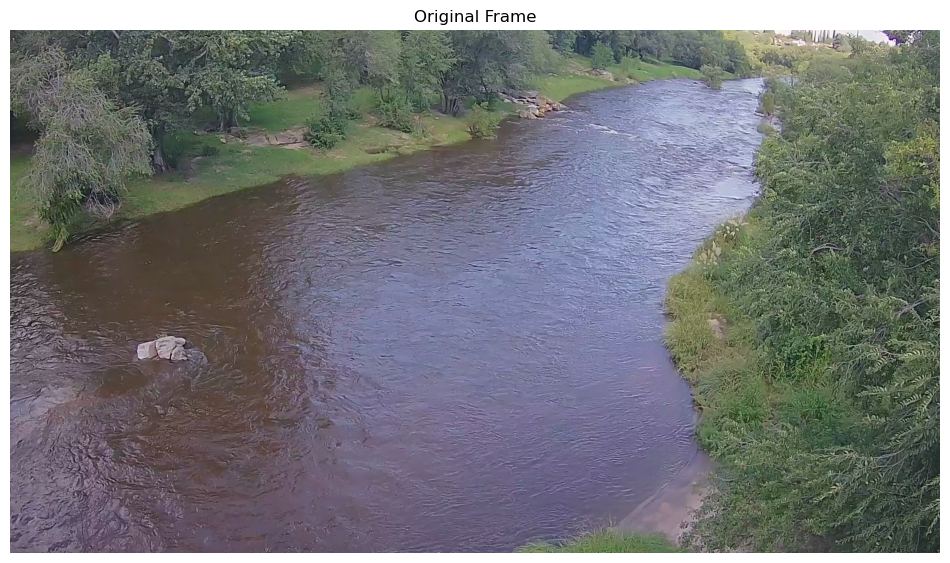

In [2]:
# Load the image
frame = cv2.imread(str(frame_path))
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Display the frame
plt.figure(figsize=(12, 8))
plt.imshow(frame_rgb)
plt.axis('off')
plt.title('Original Frame')
plt.show()

## Step 2: Load and Visualize Ground Reference Points (GRPs)

For fixed-station transformation, we need Ground Reference Points with known 3D coordinates (X, Y, Z). These points are critical for establishing the relationship between image space and real-world space. Effective GRPs should:

- Be well distributed across the frame, especially in the area of interest
- Include points at different distances from the camera to capture depth
- Have accurately measured real-world coordinates with minimal error
- Be visible and identifiable in the video frames
- Include features that are stable over time (e.g., permanent structures, installed markers)

In practice, collecting good GRPs often requires field surveys using total stations, RTK-GPS, or other surveying equipment. For this example, we'll load pre-measured GRPs from a JSON file.


In [3]:
# Load the GRPs from the JSON file
# The file contains dictionaries with 'X', 'Y', 'Z' (real-world coordinates)
# and 'x', 'y' (pixel coordinates) keys
with open(grps_path, 'r') as f:
    grp_dict = json.load(f)

# Create a DataFrame for better visualization and inspection of the GRP data
# This helps us verify the quality and distribution of our reference points
import pandas as pd

# Create point IDs for easier reference
# Get the number of points from any coordinate array in the dictionary
num_points = len(grp_dict['X'])
point_ids = [f"Point {i+1}" for i in range(num_points)]

# Create a dataframe with all GRP information
# Using .get() with default values ensures the code doesn't break if a key is missing
df = pd.DataFrame({
    'Point ID': point_ids,
    'X (real world)': grp_dict.get('X', [None] * num_points),  # Easting or longitudinal coordinate
    'Y (real world)': grp_dict.get('Y', [None] * num_points),  # Northing or lateral coordinate
    'Z (real world)': grp_dict.get('Z', [None] * num_points),  # Elevation
    'x (pixel)': grp_dict.get('x', [None] * num_points),       # Horizontal pixel coordinate
    'y (pixel)': grp_dict.get('y', [None] * num_points)        # Vertical pixel coordinate
})

# Set Point ID as index for cleaner display
df.set_index('Point ID', inplace=True)

# Display the table with formatted values
print("Ground Reference Points (GRPs)")
display(df.style.format({
    'X (real world)': '{:.3f}',  # 3 decimal places for real-world coordinates (meter precision)
    'Y (real world)': '{:.3f}',
    'Z (real world)': '{:.3f}',
    'x (pixel)': '{:.2f}',       # 2 decimal places for pixel coordinates
    'y (pixel)': '{:.2f}'
}))

Ground Reference Points (GRPs)


,X (real world),Y (real world),Z (real world),x (pixel),y (pixel)
Point ID,,,,,
Point 1,4355888.710,6520302.750,647.660,1008.70,1048.00
Point 2,4355894.300,6520304.630,647.750,508.60,1058.90
Point 3,4355896.220,6520302.300,647.670,432.40,921.60
Point 4,4355895.250,6520299.480,647.680,580.70,828.60
Point 5,4355898.440,6520298.240,647.640,414.30,756.60
Point 6,4355899.180,6520296.930,647.980,416.40,691.30
Point 7,4355900.200,6520297.590,648.670,342.30,662.50
Point 8,4355901.660,6520297.680,648.650,267.40,651.40
Point 9,4355902.870,6520298.250,647.680,198.40,704.50


## Step 3: Calculate Camera Solution

Now we'll use the `get_camera_solution` function to compute the camera matrix that transforms between pixel and real-world coordinates.


In [4]:
cam_solution = get_camera_solution(grp_dict, image_path=frame_path)

# Print camera position and error
print(f"Camera position (X, Y, Z): {cam_solution['camera_position']}")
print(f"Mean reprojection error: {cam_solution['error']:.4f} pixels")

# Optimized camera solution
print("\nCalculating optimized camera solution...")
try:
    cam_solution_optimized = get_camera_solution(
        grp_dict, 
        image_path=frame_path, 
        optimize_solution=True
    )
    print(f"Used {cam_solution_optimized['num_points']} points for optimization")
    print(f"Points used: {cam_solution_optimized['point_indices']}")
    print(f"Camera position (X, Y, Z): {cam_solution_optimized['camera_position']}")
    print(f"Mean reprojection error: {cam_solution_optimized['error']:.4f} pixels")
    
    # Use the optimized solution if available
    cam_solution = cam_solution_optimized
except Exception as e:
    print(f"Optimization failed: {e}")
    print("Using basic camera solution instead.")


Camera position (X, Y, Z): [4355885.267689137, 6520318.761178266, 659.60385347595]
Mean reprojection error: 12.4729 pixels

Calculating optimized camera solution...
Used 12 points for optimization
Points used: (1, 3, 11, 13, 26, 27, 32, 33, 37, 41, 43, 44)
Camera position (X, Y, Z): [4355883.543948429, 6520324.9463289855, 661.3946338053704]
Mean reprojection error: 12.1230 pixels


## Step 4: Visualize the Transformation

Let's visualize how the transformation works by showing the original image with GRPs and the orthorectified view.


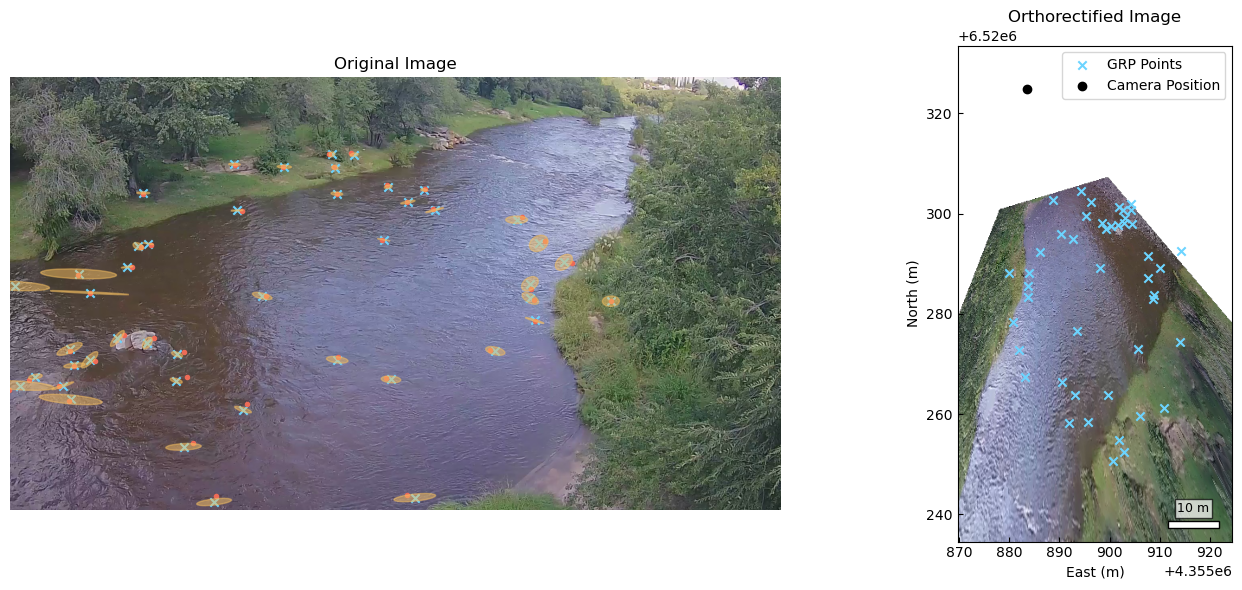

In [5]:
fig = plot_camera_solution(frame_rgb, grp_dict, cam_solution)
plt.show()

## Step 5: Save the Camera Matrix for Future Use

Finally, we'll save the camera solution to a JSON file for use in subsequent processing steps.


In [6]:
# Convert camera matrix (numpy array) to list for JSON serialization
output_file = output_dir / "transformation.json"

# Create a serializable version of the camera solution
cam_solution = {
    'camera_matrix': cam_solution['camera_matrix'],
    'camera_position': cam_solution['camera_position'],
    'error': float(cam_solution['error']),
}

# Save to JSON file
with open(output_file, 'w') as f:
    json.dump(cam_solution, f, indent=2)

print(f"Camera solution saved to {output_file}")

Camera solution saved to results/juncal/transformation.json


## Common Issues and Troubleshooting

1. **High Reprojection Error:**
   - Ensure GRP measurements are accurate
   - Check if GRPs are correctly marked in the image
   - Add more GRPs or redistribute them across the scene
   - Use the optimized solution which automatically selects the best subset of points

2. **Distorted Orthorectified View:**
   - GRPs may be coplanar (all points at same elevation) - ensure points are at different elevations
   - Ensure GRPs cover a wide area of the image
   - Verify that the Z-coordinate measurements are accurate

Remember that fixed-station transformation requires precise GRP measurements.